# LSTM Recurrent Neural Network for Predicting the price of a Stock

In [4]:
#1-Import basic libraries 
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [5]:
#2-Download stock data
data=yf.download('AAPL')[['Adj Close']]
data.reset_index(inplace=True)
data.drop('Date', axis=1, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [6]:
#3-Data pre-processing 

#Split into train and test set
split_percentage=0.97
split_point=round(len(data)*split_percentage)
train_data=data.iloc[:split_point]
test_data=data.iloc[split_point:]

#Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(test_data)

#4-Transform the data to use it like a time series, Xs will have a shape of (#Samples, #Lags) and Ys of (#Samples,)
def timeseries_preprocessing(scaled_train, scaled_test, lags):
    X,Y = [],[]
    for t in range(len(scaled_train)-lags-1):
        X.append(scaled_train[t:(t+lags),0])
        Y.append(scaled_train[(t+lags),0])
    
    Z,W = [],[]
    for t in range(len(scaled_test)-lags-1):
        Z.append(scaled_test[t:(t+lags),0])
        W.append(scaled_test[(t+lags),0])
        
    X_train, Y_train, X_test, Y_test=np.array(X), np.array(Y), np.array(Z),np.array(W)
    
    #Reshape Xs as (Sample,Timestep,Features), reshape is necessary for keras to understand
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
    
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test=timeseries_preprocessing(scaled_train, scaled_test, 10)

In [7]:
#5-Create the model
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(256,input_shape=(X_train.shape[1],1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

#6-Fit model with a validation set to check for overfitting
history = model.fit(x=X_train,y=Y_train,epochs=300,validation_data=(X_test,Y_test),shuffle=False)

Train on 9790 samples, validate on 292 samples
Epoch 1/300
9790/9790 [==============================] - 6s 612us/sample - loss: 2.8846e-04 - val_loss: 0.0928
Epoch 2/300
9790/9790 [==============================] - 4s 416us/sample - loss: 9.8909e-04 - val_loss: 0.0667
Epoch 3/300
9790/9790 [==============================] - 5s 477us/sample - loss: 0.0015 - val_loss: 0.0668
Epoch 4/300
9790/9790 [==============================] - 4s 451us/sample - loss: 0.0012 - val_loss: 0.0186
Epoch 5/300
9790/9790 [==============================] - 4s 459us/sample - loss: 5.1953e-04 - val_loss: 0.0077
Epoch 6/300
9790/9790 [==============================] - 4s 451us/sample - loss: 3.3025e-04 - val_loss: 0.0019
Epoch 7/300
9790/9790 [==============================] - 4s 457us/sample - loss: 8.2989e-05 - val_loss: 0.0019
Epoch 8/300
9790/9790 [==============================] - 5s 460us/sample - loss: 7.4790e-05 - val_loss: 0.0018
Epoch 9/300
9790/9790 [==============================] - 4s 455us/sample 

Model accuracy (%)
62.81665228520856

Prediction performance
MAE in % 6.861448835199405
MSE 70.29982703716699
RMSE 8.384499212067885
R2 0.8639681007776617


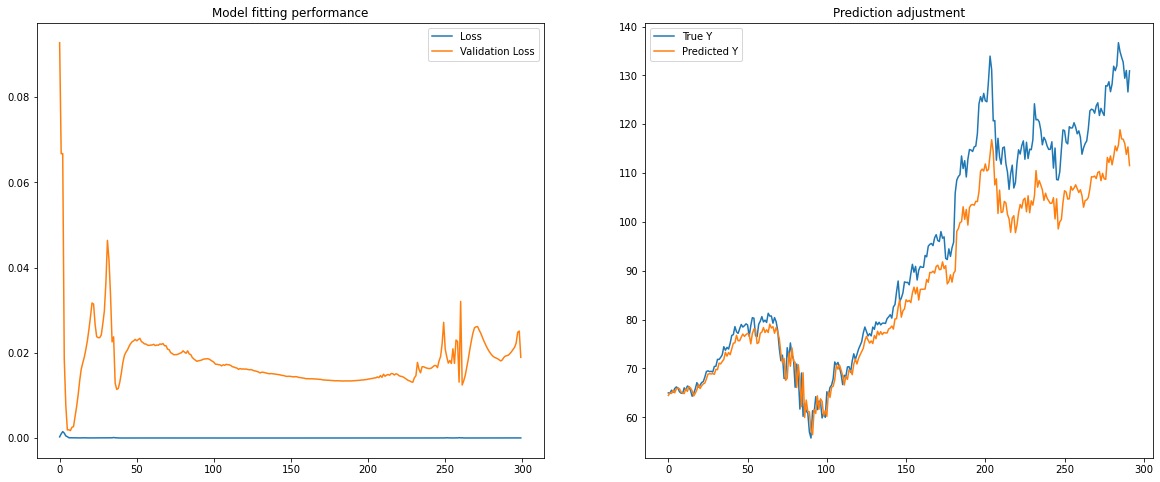

In [8]:
#7-Evaluate the model
Y_predicted=scaler.inverse_transform(model.predict(X_test))
Y_true=scaler.inverse_transform(Y_test.reshape(Y_test.shape[0],1))

fig,axes=plt.subplots(1,2,figsize=(20,8))
axes[0].plot(pd.DataFrame(model.history.history)['loss'], label='Loss')
axes[0].plot(pd.DataFrame(model.history.history)['val_loss'], label='Validation Loss')
axes[0].legend(loc=0)
axes[0].set_title('Model fitting performance')

axes[1].plot(Y_true, label='True Y')
axes[1].plot(Y_predicted, label='Predicted Y')
axes[1].legend(loc=0)
axes[1].set_title('Prediction adjustment')

from sklearn import metrics
print('Model accuracy (%)')
Y_p=scaler.inverse_transform(model.predict(X_train))
Y_t=scaler.inverse_transform(Y_train.reshape(Y_train.shape[0],1))
print((1-(metrics.mean_absolute_error(Y_t, Y_p)/Y_t.mean()))*100)
print('')
print('Prediction performance')
print('MAE in %', (metrics.mean_absolute_error(Y_true, Y_predicted)/Y_true.mean())*100)
print('MSE', metrics.mean_squared_error(Y_true, Y_predicted))
print('RMSE',np.sqrt(metrics.mean_squared_error(Y_true, Y_predicted)))
print('R2', metrics.r2_score(Y_true, Y_predicted))

In [9]:
#Precise accuracy 
lista=[]
for t in range(1,Y_predicted.shape[0]):
    if Y_predicted[t]>Y_predicted[t-1] and Y_true[t]>Y_true[t-1]:
        lista.append(1)
    
    if Y_predicted[t]<Y_predicted[t-1] and Y_true[t]<Y_true[t-1]:
        lista.append(1)
    
    else:
        lista.append(0)
print('Precise Accuracy:', sum(lista)/Y_predicted.shape[0])

Precise Accuracy: 0.4315068493150685


In [10]:
#Make forecast
def predictions(lags, df, days_ahead):
    batch=scaler.transform(data[-lags:])
    current_batch=np.array(batch[:lags]).reshape(1, batch.shape[0],batch.shape[1])
    
    forecast=[]
    for t in range(0, days_ahead):
        current_pred=model.predict(current_batch)[0]
        forecast.append(list(scaler.inverse_transform(current_pred.reshape(1,1)).reshape(1))[0])
        current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    return forecast

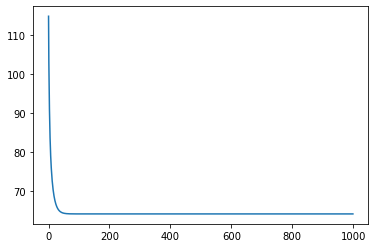

In [11]:
plt.plot(predictions(10, data, 1000))

In [ ]:
#Save or load model
from tensorflow.keras.models import load_model
model.save('LSTM_stock_prices')
my_model = load_model('LSTM_stock_prices')